# Constants

In [1]:
const kb = 1.38064852e-23

1.38064852e-23

# Lattice site
Let's define a type called LatticeSite that contains two associated vector potential link variables $A_{\mathbf{r},x},A_{\mathbf{r},y}\in(-\infty,\infty)$, two real numbers $\theta^\pm\in [0,2\pi]$ corresponding to the phases of the superconducting order parameters, as well as an amplitude $u_\mathbf{r}\in[0,1]$ that gives the amplitude of the $+$ component.
The vector potential is split in a static and fluctuating part, but we take care of the static part in the calculation of energies and thus only need to store the fluctuating part in each lattice site.

In [1]:
type LatticeSite
    A::Array{Float64,1}  # Fluctuating vector potential
    θ⁺::Float64 # Phase of the + component
    θ⁻::Float64 # Phase of the - component
    u⁺::Float64 # Amplitude of + component
end

# State
We will have a state type that contains all information about the state of the system at a particular time

This will need to contain a lattice of lattice points $\mathbf{r}$ of type LatticeSite as well as two amplitudes of the order parameter $\rho_\pm\in[0,\infty]$.

In [3]:
r = LatticeSite([2,3], 4, 4, 0)
b = LatticeSite([0,0], 3, 3, 1)

LatticeSite([0.0, 0.0], 3.0, 3.0, 1.0)

In [4]:
w = hcat([[b,b], [r,r]]...)

2×2 Array{LatticeSite,2}:
 LatticeSite([0.0, 0.0], 3.0, 3.0, 1.0)  …  LatticeSite([2.0, 3.0], 4.0, 4.0, 0.0)
 LatticeSite([0.0, 0.0], 3.0, 3.0, 1.0)     LatticeSite([2.0, 3.0], 4.0, 4.0, 0.0)

In [5]:
w[1, 2]

LatticeSite([2.0, 3.0], 4.0, 4.0, 0.0)

In [2]:
type State
    lattice::Array{LatticeSite,2}  # Numerical lattice
    γ::Float64    # Order parameter amplitude
    g::Float64    # Gauge coupling
    ν::Float64    # Anisotropy constant
    f::Float64    # Magnetic filling fraction
end

We create a function "initializeState" that initializes a state as a $N\times N$ lattice of either
1. Completely ordered state
2. Completely random state

Since we have split the vector potential $\mathbf{A}$ into a fixed part $\mathbf{A}_0 = (0, 2\pi xf, 0)$ and a
fluctuating part $\mathbf{A}_\text{fluc}$, we have to make sure the link variables $A_{\mathbf{r},\mu}$ is set
accordingly. This should ensure that $\oint_C(\mathbf{A}_0+\mathbf{A}_\text{fluc})= 2\pi fL^2$ for a lattice with
dimensions $L\times L$, magnetic filling fraction $f$ and where $C$ is a contour around the lattice. This is true because
$\mathbf{A}_\text{fluc}$ has periodic boundary conditions, thus the integral vanishes. The line-integral over
$\mathbf{A}_0$ only gets a contribution from the right hand $y$-axis.

In [7]:
rand()*2^10*(-1)^rand(0:1)

231.06298393273437

In [3]:
function initializeState(N::Int64, choice::Int64)
    N <= 1 && throw(DomainError())
    
    # Constants
    γ = 1.0    # Order parameter amplitude
    g = 1.0    # Gauge coupling
    ν = 0.0    # Anisotropy constant
    f = 1/32    # Magnetic filling fraction
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
        lattice = [LatticeSite([rand()*Amax*(-1)^rand(0:1),rand()*Amax*(-1)^rand(0:1)],
                rand()*2*π,rand()*2*π, rand()) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end

initializeState (generic function with 1 method)

In [4]:
lattice = [LatticeSite([0,0],0,0,0) for y=1:4, x=1:3]
lattice

4×3 Array{LatticeSite,2}:
 LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)  …  LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)
 LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)     LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)
 LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)     LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)
 LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)     LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)

# Calculation of energy

To evaluate the acceptance probability we need to calculate the difference in energy from state $\Psi_i \to \Psi_{i+1}$. Since we will be doing local updates, there is no need to iterate over the entire lattice to find the energy of each state and then subtract. For the difference we simply need to know the energy difference associated with the local update.

In [16]:
function fᵣ(θ⁺::Float64, θ⁻::Float64, θx⁺::Float64, θx⁻::Float64, θy⁺::Float64, θy⁻::Float64, 
        u⁺::Float64, u⁻::Float64, ux⁺::Float64, ux⁻::Float64, uy⁺::Float64, uy⁻::Float64, 
        A₁::Float64, A₂::Float64, γ::Float64, g::Float64, ν::Float64, f::Float64)
    energy = 0
    # Kinetic energy Fₖ
    energy += -2*γ^2*(ux⁺*u⁺*cos(θx⁺-θ⁺ + g*A₁) 
        + uy⁺*u⁺*cos(θy⁺-θ⁺ + g*A₂) 
        + ux⁻*u⁻*cos(θx⁻-θ⁻ + g*A₁) 
        + uy⁻*u⁻*cos(θy⁻-θ⁻ + g*A₂) )
    # Potential energy Fᵥ
    energy += γ^4*u⁺^2+u⁻^2*(1+ν*cos(2*(θ⁺-θ⁻)))
    # Mixed gradient terms cos() part
    energy += γ^2*(ν+1)*(u⁻*uy⁺*cos(θy⁺-θ⁻ + g*A₂) 
        + u⁺*uy⁻*cos(θy⁻-θ⁺ + g*A₂) 
        - u⁻*ux⁻*cos(θx⁺ - θ⁻ + g*A₁) 
        - u⁺*ux⁻*cos(θx⁻ - θ⁺ + g*A₁))
    # Mixed gradient sin() part
    energy += γ^2*(ν-1)*(uy⁺*ux⁻*sin(θx⁻ - θy⁺ + g*(A₁-A₂)) 
        - uy⁻*ux⁺*sin(θx⁺ - θy⁻ + g*(A₁ - A₂)) 
        + 2*u⁺*u⁻*sin(θ⁻-θ⁺) 
        -  u⁻*uy⁺*sin(θy⁺-θ⁻ + g*A₂) 
        + u⁺*uy⁻*sin(θy⁻-θ⁺ + g*A₂) 
        + u⁻*ux⁻*sin(θx⁺ - θ⁻ + g*A₁) 
        - u⁺*ux⁻*sin(θx⁻ - θ⁺ + g*A₁))
    energy
end

fᵣ (generic function with 1 method)

In [14]:
# Loops over all positions of the lattice of a state and calculates the total energy from the
# Higgs-field terms using the function fᵣ() + the energy from the gauge field.
function E(ψ::State)
    γ = ψ.γ
    g = ψ.g
    energy = 0
    ν = ψ.ν
    f = ψ.f
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    
    # Contribution from upper right corner
    A⁰ = (Lx-1)*2π*f
    r = ψ.lattice[1,Lx]    # Lattice site at upper right corner
    rx = ψ.lattice[1,1]    # Nearest neighbor at r+x is upper left corner
    ry = ψ.lattice[Ly,Lx]  # Nearest neighbor at r+y is lower right corner
    energy += fᵣ(r.θ⁺,r.θ⁻,rx.θ⁺,rx.θ⁻,ry.θ⁺,ry.θ⁻,r.u⁺,√(1-r.u⁺^2),rx.u⁺,√(1-rx.u⁺^2),ry.u⁺,√(1-ry.u⁺^2),
        r.A[1],r.A[2]+A⁰,γ,g,ν,f)                 # Higgs field
    energy += (r.A[1] + rx.A[2]-ry.A[1]-r.A[2])^2 # Maxwell term
    
    # Contribution from right boundary paralell to y-axis
    # except for the upper right corner.
    for y=2:Ly
        r = ψ.lattice[y,Lx]
        rx = ψ.lattice[y,1]
        ry = ψ.lattice[y-1,Lx]
        A⁰ = (Lx-1)*2*π*f
        energy += fᵣ(r.θ⁺,r.θ⁻,rx.θ⁺,rx.θ⁻,ry.θ⁺,ry.θ⁻,r.u⁺,√(1-r.u⁺^2),rx.u⁺,√(1-rx.u⁺^2),ry.u⁺,√(1-ry.u⁺^2),
            r.A[1],r.A[2]+A⁰,γ,g,ν,f)
        energy += (r.A[1] + rx.A[2]-ry.A[1]-r.A[2])^2
    end
    
    # Contribution from the bulk of lattice sites and upper boundary
    for x=1:(Lx-1)
        A⁰ = (x-1)*2*π*f        # Constant vector potential.
        # Constribution from upper boundary except upper right corner
        r = ψ.lattice[1,x]
        rx = ψ.lattice[1,x+1]
        ry = ψ.lattice[Ly,x]
        energy += fᵣ(r.θ⁺,r.θ⁻,rx.θ⁺,rx.θ⁻,ry.θ⁺,ry.θ⁻,r.u⁺,√(1-r.u⁺^2),rx.u⁺,√(1-rx.u⁺^2),ry.u⁺,√(1-ry.u⁺^2),
            r.A[1],r.A[2]+A⁰,γ,g,ν,f)
        energy += (r.A[1] + rx.A[2]-ry.A[1]-r.A[2])^2
        
        # Contribution from the rest of the bulk.
        for y=2:size(ψ.lattice,1)
            r = ψ.lattice[y,x]          # Lattice site at position r
            rx = ψ.lattice[y,x+1]       # Nearest neighbor at r+x
            ry = ψ.lattice[y-1,x]       # Nearest neighbor at r+y
            
            energy += fᵣ(r.θ⁺,r.θ⁻,rx.θ⁺,rx.θ⁻,ry.θ⁺,ry.θ⁻,r.u⁺,√(1-r.u⁺^2),rx.u⁺,√(1-rx.u⁺^2),ry.u⁺,√(1-ry.u⁺^2),
                r.A[1],r.A[2]+A⁰,γ,g,ν,f)
            energy += (r.A[1] + rx.A[2]-ry.A[1]-r.A[2])^2
        end
    end
    
    energy
end
            

E (generic function with 1 method)

In [8]:
ψ = initializeState(2, 1)

State(LatticeSite[LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0) LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0); LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0) LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)], 1.0, 1.0, 0.0, 0.03125)

In [9]:
size(ψ.lattice,1)

2

In [11]:
ψ.lattice

2×2 Array{LatticeSite,2}:
 LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)  …  LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)
 LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)     LatticeSite([0.0, 0.0], 0.0, 0.0, 0.0)

In [17]:
E(ψ)

-15.923141121612922

Let's do a unit test that the energy function acts as expected.

In [12]:
# Tests mostly that the kinetic energy Fₖ is correctly calculated.
using Base.Test
f = 1.0/33
ψ = initializeState(2, 1)
@test E(ψ) == -4*(3+cos(2*π*1/32))

Test Passed

In addition to having a function that goes through the whole lattice and calculates the energy of its current configuration $\Psi_i$, we also want to have a function that takes in a local update of a lattice site $\mathbf{r}_i\to\mathbf{r}_{i+1}$ and calculates
the change in energy $\Delta E_{i,i+1}$ if the lattice was updated to have the proposed change at the particular lattice site $\Psi_i\to\Psi_{i+1}$.

This function thus only needs to sum over the nearest neighbours of the lattice site $\mathbf{r}_i$ since the energy is given as a sum over lattice sites where only the nearest neighbors are coupled.

When changing the values of a lattice site $\mathbf{r}$ in the state $\Psi$, the energy difference associated with this change
 is the sum of energy terms in $F$ where $\mathbf{r}$ occurs. Since the evaulation of lattice sites in $F$ takes
for form of $\mathbf{r}$, $\mathbf{r}+\hat{x}$ and $\mathbf{r}+\hat{y}$, it is clear that when changing the values at lattice site $\mathbf{r}$, only some of
 the terms in the free energy density when it was evaluated at $\mathbf{r}'=\mathbf{r}-\hat{x}$ and $\mathbf{r}'=\mathbf{r}-\hat{y}$ changes. Specifically
 the kinetic density $\mathcal{F}_K(\mathbf{r}')$, $\mathcal{F}_\text{MGT}(\mathbf{r}')$ and $\mathcal{F}_A(\mathbf{r}')$ has to be evaluated in addition to $\mathcal{F}(\mathbf{r})$ to obtain
 the energy difference.

In [19]:
1*(1
+ 1
+ 2)

4

In [39]:
# Energy difference functions

# Find the local kinetic energy difference at r caused by two different sites at r+i,
# one that is primed and one not.
function ΔKinetic(θ′⁺ᵣ₊ᵢ::Float64,θ′⁻ᵣ₊ᵢ::Float64,θ⁺ᵣ₊ᵢ::Float64,θ⁻ᵣ₊ᵢ::Float64,θ⁺::Float64,θ⁻::Float64,
        u′⁺ᵣ₊ᵢ::Float64,u′⁻ᵣ₊ᵢ::Float64,u⁺ᵣ₊ᵢ::Float64,u⁻ᵣ₊ᵢ::Float64,u⁺::Float64,u⁻::Float64,
        Aᵣᵢ::Float64,γ::Float64,g::Float64)
    -2*γ^2(u⁺*(u′⁺ᵣ₊ᵢ*cos(θ′⁺ᵣ₊ᵢ - θ⁺ + g*Aᵣᵢ) - u⁺ᵣ₊ᵢ*cos(θ⁺ᵣ₊ᵢ - θ⁺ + g*Aᵣᵢ))
        + u⁻*(u′⁻ᵣ₊ᵢ*cos(θ′⁻ᵣ₊ᵢ - θ⁻ + g*Aᵣᵢ) - u⁻ᵣ₊ᵢ*cos(θ⁻ᵣ₊ᵢ - θ⁻ + g*Aᵣᵢ)))
end

# Calculates the local contribution from mixed gradient terms to total free energy
function fMGT(θ⁺ᵣ₊₁::Float64,θ⁻ᵣ₊₁::Float64,θ⁺ᵣ₊₂::Float64,θ⁻ᵣ₊₂::Float64,θ⁺::Float64,θ⁻::Float64,
        u⁺ᵣ₊₁::Float64,u⁻ᵣ₊₁::Float64,u⁺ᵣ₊₂::Float64,u⁻ᵣ₊₂::Float64,u⁺::Float64,u⁻::Float64,
        A₁::Float64,A₂::Float64,γ::Float64,g::Float64,ν::Float64)
    γ^2*((ν+1)*(u⁻*u⁺ᵣ₊₂*cos(θ⁺ᵣ₊₂-θ⁻+g*A₂) + u⁺*u⁻ᵣ₊₂*cos(θ⁻ᵣ₊₂-θ⁺+g*A₂) 
            - u⁻*u⁺ᵣ₊₁*cos(θ⁺ᵣ₊₁-θ⁻+g*A₁) - u⁺*u⁻ᵣ₊₁*cos(θ⁻ᵣ₊₁-θ⁺+g*A₁))
    +(ν-1)*(u⁺ᵣ₊₂*u⁻ᵣ₊₁*sin(θ⁻ᵣ₊₁-θ⁺ᵣ₊₂ + g*(A₁-A₂)) - u⁻ᵣ₊₂*u⁺ᵣ₊₁*sin(θ⁺ᵣ₊₁-θ⁻ᵣ₊₂ + g*(A₁-A₂)) 
            + 2*u⁺*u⁻*sin(θ⁻-θ⁺) # Because of this term we will be adding some zeros when taking energy differences.
            + u⁻*u⁺ᵣ₊₁*sin(θ⁺ᵣ₊₁-θ⁻+g*A₁) - u⁺*u⁻ᵣ₊₁*sin(θ⁻ᵣ₊₁-θ⁺+g*A₁) 
            - u⁻*u⁺ᵣ₊₂*sin(θ⁺ᵣ₊₂-θ⁻+g*A₂) + u⁺*u⁻ᵣ₊₂*sin(θ⁻ᵣ₊₂-θ⁺+g*A₂)))
end

fMGT (generic function with 1 method)

In [40]:
fMGT(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, )

0.0

In [48]:
# Calculate change in energy of the total free energy F when changing the lattice
# site of ψ at r to the lattice "site"
#    In the first iteration of this function we assume that r is in the bulk.
function ΔE(ψ::State, site::LatticeSite, pos::Array{Int64,1})
    δE = 0.0
    x = pos[1]
    y = pos[2]
    γ = ψ.γ
    g = ψ.g
    ν = ψ.ν
    f = ψ.f
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    r = ψ.lattice[y,x]
    A⁰ = 2π*f*(x-1)
    
    # First calculate the change in energy caused by evaluating F at r-x
    # Energy difference from Fₖ
    r′ = ψ.lattice[y,x-1]
    δE += ΔKinetic(site.θ⁺,site.θ⁻,r.θ⁺,r.θ⁻,r′.θ⁺,r′.θ⁻,
        site.u⁺,√(1-site.u⁺^2),r.u⁺,√(1-r.u⁺^2),r′.u⁺,√(1-r′.u⁺^2),r′.A[1],γ,g)
    # Energy difference from F MGT
    # Here there is room for optimization by defining similar function to the one for the kinetic energy.
    r′ᵣ₊₂ = ψ.lattice[y-1,x-1] # Nearest neighbor of 
    δE += (fMGT(site.θ⁺,site.θ⁻,r′ᵣ₊₂.θ⁺,r′ᵣ₊₂.θ⁻,r′.θ⁺,r′.θ⁻,
        site.u⁺,√(1-site.u⁺^2),r′ᵣ₊₂.u⁺,√(1-r′ᵣ₊₂.u⁺^2),r′.u⁺,√(1-r′.u⁺^2),
        r′.A[1],r′.A[2]+2π*f*(x-2),γ,g,ν)
        -  fMGT(r.θ⁺,r.θ⁻,r′ᵣ₊₂.θ⁺,r′ᵣ₊₂.θ⁻,r′.θ⁺,r′.θ⁻,
        r.u⁺,√(1-r.u⁺^2),r′ᵣ₊₂.u⁺,√(1-r′ᵣ₊₂.u⁺^2),r′.u⁺,√(1-r′.u⁺^2),
        r′.A[1],r′.A[2]+2π*f*(x-2),γ,g,ν))
    # Energy difference from Gauge term
    δE += (r′.A[1] + site.A[2] - r′ᵣ₊₂.A[1] - r′.A[2])^2 - (r′.A[1] + r.A[2] - r′ᵣ₊₂.A[1] - r′.A[2])^2
    
    # Now calculate the contribution from the evaluating F at r-y
    # Energy difference from Fₖ
    r′ = ψ.lattice[y+1,x]
    δE += ΔKinetic(site.θ⁺,site.θ⁻,r.θ⁺,r.θ⁻,r′.θ⁺,r′.θ⁻,
        site.u⁺,√(1-site.u⁺^2),r.u⁺,√(1-r.u⁺^2),r′.u⁺,√(1-r′.u⁺^2),r′.A[2]+A⁰,γ,g)
    # Energy difference from F MGT
    r′ᵣ₊₁ = ψ.lattice[y+1,x+1]
    δE += (fMGT(r′ᵣ₊₁.θ⁺,r′ᵣ₊₁.θ⁻,site.θ⁺,site.θ⁻,r′.θ⁺,r′.θ⁻,
        r′ᵣ₊₁.u⁺,√(1-r′ᵣ₊₁.u⁺^2),site.u⁺,√(1-site.u⁺^2),r′.u⁺,√(1-r′.u⁺^2),
        r′.A[1],r′.A[2]+A⁰,γ,g,ν) 
         - fMGT(r′ᵣ₊₁.θ⁺,r′ᵣ₊₁.θ⁻,r.θ⁺,r.θ⁻,r′.θ⁺,r′.θ⁻,
        r′ᵣ₊₁.u⁺,√(1-r′ᵣ₊₁.u⁺^2),r.u⁺,√(1-r.u⁺^2),r′.u⁺,√(1-r′.u⁺^2),
        r′.A[1],r′.A[2]+A⁰,γ,g,ν))
    # Energy difference from Gauge term
    δE += (r′.A[1] + r′ᵣ₊₁.A[2] - site.A[1] - r′.A[2])^2 - (r′.A[1] + r′ᵣ₊₁.A[2] - r.A[1] - r′.A[2])^2
    
    # Finally calculate energy difference from evaluating F at r
    rᵣ₊₁ = ψ.lattice[y,x+1]
    rᵣ₊₂ = ψ.lattice[y-1,x]
    δE += (fᵣ(site.θ⁺,site.θ⁻,rᵣ₊₁.θ⁺,rᵣ₊₁.θ⁻,rᵣ₊₂.θ⁺,rᵣ₊₂.θ⁻, 
        site.u⁺,√(1-site.u⁺^2),rᵣ₊₁.u⁺,√(1-rᵣ₊₁.u⁺^2),rᵣ₊₂.u⁺,√(1-rᵣ₊₂.u⁺^2),
        site.A[1],site.A[2]+A⁰,γ,g,ν,f) 
        - fᵣ(r.θ⁺,r.θ⁻,rᵣ₊₁.θ⁺,rᵣ₊₁.θ⁻,rᵣ₊₂.θ⁺,rᵣ₊₂.θ⁻, 
        r.u⁺,√(1-r.u⁺^2),rᵣ₊₁.u⁺,√(1-rᵣ₊₁.u⁺^2),rᵣ₊₂.u⁺,√(1-rᵣ₊₂.u⁺^2),
        r.A[1],r.A[2]+A⁰,γ,g,ν,f))
end

ΔE (generic function with 1 method)

In [59]:
ψ₁ = initializeState(3, 2)
ψ₂ = initializeState(3,2)
ψ₂.lattice

3×3 Array{LatticeSite,2}:
 LatticeSite([867.443, -406.759], 5.36234, 2.45224, 0.900525)     …  LatticeSite([122.547, 212.395], 4.56491, 2.43626, 0.129926) 
 LatticeSite([-800.921, -152.294], 3.46875, 0.805812, 0.0228894)     LatticeSite([-82.455, 694.125], 2.09391, 6.26113, 0.056973) 
 LatticeSite([-835.721, -838.029], 4.13664, 0.855568, 0.643861)      LatticeSite([54.0577, 405.888], 0.168952, 2.57329, 0.608625)

In [60]:
site = LatticeSite([0.0,0.0], 0, 0,1)
ΔE(ψ₂,ψ₂.lattice[2,2],[2,2])

-4.0

In [ ]:
# An old iteration of ΔE that uses mod to calculate nearest neighbors
#function ΔE(ψ::State, site::LatticeSite, r::Array{Int64,1})
#    δE = 0.0
#    x = r[1]
#    y = r[2]
#    Ly = size(ψ.lattice,1) # The dimension of the lattice
#    
#    # Calculate nearest neighbors of the position r, given periodic boundary conditions.
#    nn = [[y,mod(x,L)+1], # position r+x
#        [mod(y,L)+1,x],   # position r+y
#        [y,mod(x-2,L)+1], # position r-x
#        [mod(y-2,L)+1,x]] # position r-y
#    
#    for pos in nn
#        # Here we have only used an example energy A_x*A_x
#        δE += (ψ.lattice[pos...].A₀ᵣ[1] + ψ.lattice[pos...].Aᵣ[1])
#        *(site.A₀ᵣ[1] + site.Aᵣ[1] - ψ.lattice[y,x].A₀ᵣ[1] - ψ.lattice[y,x].Aᵣ[1])
#    end
#    
#    δE += (site.A₀ᵣ[1] + site.Aᵣ[1])^2 - (ψ.lattice[y,x].A₀ᵣ[1] - ψ.lattice[y,x].Aᵣ[1])^2
#end

In [16]:
L = 3
x = 3
mod(x,L)+1

1

In [17]:
L = 3
x = 1
mod(x-2,L)+1

3

In [18]:
r = [1,1]
p1 = temp.lattice[r...]

LoadError: [91mUndefVarError: temp not defined[39m

In [19]:
ψ.lattice[r...]

LatticeSite([0.0, 0.0], [0.0, 0.0], 0.0, 0.0, 0.0)

In [20]:
ΔE(ψ, p1, r)

LoadError: [91mUndefVarError: p1 not defined[39m

# Proposal of a local state update
Given a state $\Psi_i$ we want to propose a new state $\Psi_{i+1}$ that can later be accepted according to the Metropolis-Hastings algorithm. The proposal function thus has to take in a given state $\Psi_i$ and give out a new
state $\Psi_{i+1}$ as well as the energy difference between the two states since this can be effectively calculated depending on what kind of update is done to the state. Thus we don't need to call $E(\Psi)$ twice to find the difference in energy.

The local update is done at a particular lattice site where all degrees of freedom are updated, thus the function also has to know what lattice position to update.

Remember that the proposal probability for a new state $P(\Psi_i\to\Psi_j)$ has to be equal to the symmetric update

$$P(\Psi_i\to\Psi_j) = P(\Psi_j\to\Psi_i),$$

for the update to fulfill detailed balance.

So far we do a very simple thing of defining a fixed interval around the original value, from within which the new value is uniformly randomly picked. Given a value $\theta^+_\mathbf{r}$ at the lattice site $\mathbf{r}$, the new value 
$\theta'{}^+_\mathbf{r}$ is thus picked uniformly from the interval 
$$\theta'{}^+_\mathbf{r}\in(\theta^+_\mathbf{r}-\theta_\text{max},\;\theta^+_\mathbf{r}+\theta_\text{max})$$

In [21]:
function proposeLocalUpdate(ψᵢ::State, r::Array{Int64, 1})
    const θmax = 3/100 # How far away from the original value, the proposed new value for θ should be.
    const umax = 3/100 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3/100
    const x = r[1]
    const y = r[2]
    (size(ψᵢ.lattice,1) < y || size(ψᵢ.lattice,2) < x) && throw(DomainError()) # r is outside the range of the lattice.
    
    # Save the lattice site at position r in a separate variable s.
    s = ψᵢ.lattice[y,x]
    
    # Construct new configuration at lattice site.
    newLatticeSite = LatticeSite(s.A₀ᵣ, [s.Aᵣ[1]+Amax*rand()*rand([-1,1]), s.Aᵣ[2]+Amax*rand()*rand([-1,1])],
        mod(s.θ⁺ + θmax*rand()*rand([-1,1]), 2π), mod(s.θ⁻ + θmax*rand()*rand([-1,1]), 2π), 
        mod(s.uᵣ + umax*rand()*rand([-1,1]),1))
    
    # Calculate energy difference between the two configurations and return this with the proposed lattice site.
    (newLatticeSite, ΔE(ψᵢ,newLatticeSite,r))
end    

proposeLocalUpdate (generic function with 1 method)

In [22]:
mod(-0.001, 2π)

6.282185307179586

In [23]:
-0.001 % 2π

-0.001

In [24]:
mod(-0.001,1)

0.999

In [25]:
A = zeros(2,3)
size(A,1)

2

In [26]:
ψ.lattice[1,1]

LatticeSite([0.0, 0.0], [0.0, 0.0], 0.0, 0.0, 0.0)

In [27]:
proposeLocalUpdate(ψ, [1,1])[2]

0.0005231232307729393

# Metropolis Hastings update

Now we create a function that implements the acceptance step of the Metropolis Hastings algorithm.
1. From state $\Psi_i$, propose a new state $\Psi_{i+1}$
2. Calculate $\Delta E_{i,i+1}$.
3. Generate a random number r between $(0,1]$.
4. If $r\leq e^{-\beta\Delta E_{i,i+1}}$, accept the state

Since the 
> rand() 

function creates a random number in $[0,1)$ we create a random number in $(0,1]$ by mapping $0\mapsto1$.

In [28]:
function metropolisHastingUpdate!(ψ::State, r::Array{Int64,1}, β::Float64)
    (site, δE) = proposeLocalUpdate(ψ,r)
    
    # Create random number ran ∈ (0,1].
    ran = rand()
    if ran==0
        ran=1
    end
    
    # Update state with probability min(1, e^{-β⋅δE})
    # and return the energy of final state regardless of whether it gets updated or not.
    if log(ran) <= -β*δE
        ψ.lattice[r...] = site
        δE
    else
        δE = 0
    end
end

metropolisHastingUpdate! (generic function with 1 method)

In [29]:
(x,y) = (1,3)

(1, 3)

In [30]:
y

3

In [31]:
ψ.lattice

2×2 Array{LatticeSite,2}:
 LatticeSite([0.0, 0.0], [0.0, 0.0], 0.0, 0.0, 0.0)  …  LatticeSite([0.0, 0.1904], [0.0, 0.0], 0.0, 0.0, 0.0)
 LatticeSite([0.0, 0.0], [0.0, 0.0], 0.0, 0.0, 0.0)     LatticeSite([0.0, 0.1904], [0.0, 0.0], 0.0, 0.0, 0.0)

In [32]:
metropolisHastingUpdate!(ψ, [1,1], 1/4)

0.00017378092037991476

# Monte Carlo sweep

Try to update the entire lattice once.

In [33]:
function mcSweep!(ψ::State, β::Float64)
    
    # Find size of the lattice L
    L = size(ψ.lattice,1)
    
    # Do a Metropolis-Hastings update for all lattice sites on the lattice.
    for x in 1:L, y in 1:L
        metropolisHastingUpdate!(ψ, [x,y], β)
    end
end

mcSweep! (generic function with 1 method)

# Main MC measurements function

This is the function that will do all the work. Here we call all the other functions we have created.

After $M_\text{th}$ Monte-Carlo sweeps (MCS) we do a measurement. Before doing any measurements we wait
$M_\text{skip}$ MCS for the system to reach equilibrium. We do $M$ measurements. Let the lattice be of size $N\times N$,
the magnetic filling fraction is $f$ while $\beta$ is the inverse temperature.

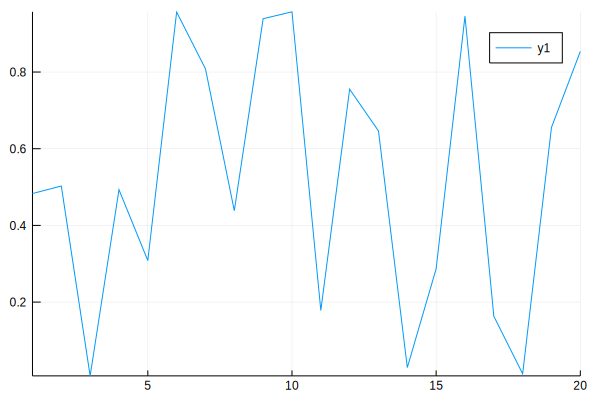

In [44]:
using Plots
gr()
plot(1:20, [rand() for i=1:20])

In [47]:
function mcMeasure(M::Int64, Mth::Int64, Mskip::Int64, N::Int64, f::Float64, β::Float64)
    ψ = initializeState(N, f, 2)
    
    # As an example we just want to measure the energies of the states.
    e = zeros(M)
    
    # Thermalize the system
    for i=1:Mskip
        mcSweep!(ψ,β)
    end
    
    # Then do M measurements
    for i=1:(M-1)
        e[i] = E(ψ)
        for j=1:Mth-1
            mcSweep!(ψ,β)
        end
    end
    e[M] = E(ψ)
    
    # Plot results
    plot(1:M, e)
end 

mcMeasure (generic function with 1 method)

In [45]:
zeros(3)

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

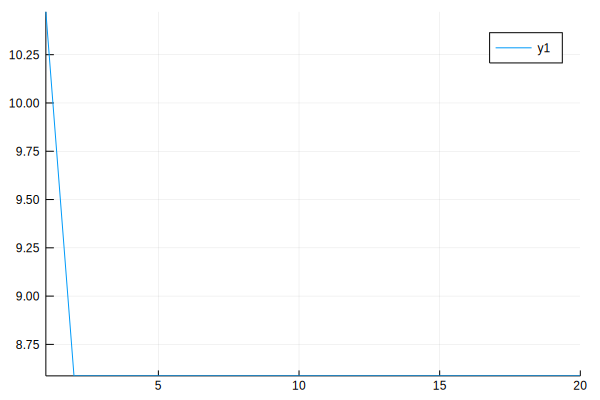

In [52]:
mcMeasure(20, 10, 0, 5, 1/30, 1/4)